In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os
import matplotlib.image as mpimg
import pandas as pd

2025-10-09 07:21:48.666309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759994509.140397      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759994509.279110      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!rm -r results

rm: cannot remove 'results': No such file or directory


In [3]:
def get_data(dataset_name):

    if dataset_name=='cifar10':
        (train_images, train_labels), (test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

        images= np.concatenate([train_images, test_images], axis=0)
        labels= np.concatenate([train_labels, test_labels], axis=0)

        print(images.shape, labels.shape)
        return images, labels

    else:
        (train_images, train_labels), (test_images, test_labels)= tf.keras.datasets.mnist.load_data()

        images= np.concatenate([train_images, test_images], axis=0)
        images= np.expand_dims(images, axis= -1)
        labels= np.concatenate([train_labels, test_labels], axis=0)

        print(images.shape, labels.shape)
        return images, labels

In [22]:
def plot_plots(dataset_name, path):
    plot_dir= path

    img_plots= [f for f in os.listdir(plot_dir) if f.startswith(dataset_name) and f.endswith(('.png', '.jpg'))]

    for img_file in img_plots:
        img_path= os.path.join(plot_dir, img_file)
        img= mpimg.imread(img_path)
        plt.figure(figsize= (8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.show()


In [5]:
def get_image_augmentation():
  train_datagen = ImageDataGenerator(
        rotation_range=20,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale= 1./255
    )

  test_datagen= ImageDataGenerator(rescale= 1./255)

  return train_datagen, test_datagen

In [21]:
'''
if not os.path.exists('results'):
  os.mkdir('results')
if not os.path.exists('results/plots'):
  os.mkdir('results/plots')
'''
# all plotting stuff will be here !!
def plot_history(history, name):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend(); plt.title(f'Accuracy for {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(); plt.title(f'Loss for {name}')
    plt.savefig(f'results/plots/{name}_history.png')
    plt.close()


def plot_confusion(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {name}')
    plt.savefig(f'results/plots/{name}_confusion.png')
    plt.close()


def plot_roc_auc(y_true, y_score, n_classes, name):
    # y_true: integer labels; y_score: probs
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro-average
    fpr['micro'], tpr['micro'], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=1, label=f'class {i} (AUC={roc_auc[i]:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC curves for {name}')
    plt.legend(loc='lower right')
    plt.savefig(f'results/plots/{name}_roc.png')
    plt.close()

In [7]:
# this is for both mnist and cifar
def simple_cnn(input_shape, classes= 10):
  model= tf.keras.models.Sequential(
    [
       tf.keras.layers.Conv2D(64, (3, 3), activation="relu",padding="same", input_shape= input_shape),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.MaxPool2D(2, strides=2, padding="valid"),
       tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.MaxPooling2D(2, strides= 2, padding="valid"),
       tf.keras.layers.Dropout(0.2),

       tf.keras.layers.Conv2D(256, (3, 3), activation= "relu", padding="same"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Conv2D(256, (3, 3), activation= "relu", padding="same"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.MaxPooling2D(2, strides= 2, padding="valid"),
       tf.keras.layers.Dropout(0.2),

       tf.keras.layers.Conv2D(512, (3, 3), activation= "relu", padding="same"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.Conv2D(512, (3, 3), activation= "relu", padding="same"),
       tf.keras.layers.BatchNormalization(),
       tf.keras.layers.MaxPooling2D(2, strides= 2, padding="valid"),
       tf.keras.layers.Dropout(0.3),

       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(256, activation="relu"),
       tf.keras.layers.Dropout(0.3),
       tf.keras.layers.Dense(128, activation="relu"),
       tf.keras.layers.Dense(classes, activation="softmax")
    ]
  )
  return model

def build_vgg_cifar(input_shape, num_classes, freeze_base=True):
    base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    if freeze_base:
        base.trainable = False

    for layer in base.layers[-10:]:
        layer.trainable=True
    model= tf.keras.models.Sequential(
        [
          tf.keras.layers.RandomFlip("horizontal"),
          tf.keras.layers.RandomRotation(0.1),
          tf.keras.layers.Resizing(224, 224),
          tf.keras.layers.Rescaling(1./255),
          #preprocess_input,
          base,
          tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
    return model

# this is for mnist dataset
def build_vgg16_transfer(input_shape, num_classes, freeze_base=True):
    base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    if freeze_base:
        base.trainable = False
    model= tf.keras.models.Sequential(
        [
          tf.keras.layers.RandomFlip("horizontal"),
          tf.keras.layers.RandomRotation(0.1),
          tf.keras.layers.Resizing(224, 224),
          tf.keras.layers.Rescaling(1./255),
          #preprocess_input,
          base,
          tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
    return model


def build_alexnet(input_shape, num_classes):
    # A Keras-style AlexNet (simplified)

    inp= tf.keras.layers.Input(shape=[None, None, 3])
    x = tf.keras.layers.RandomFlip("horizontal")(inp)
    x = tf.keras.layers.RandomRotation(0.1)(x)
    x = tf.keras.layers.Resizing(224, 224)(x)
    x = tf.keras.layers.Rescaling(1./255)(x)
    x = tf.keras.layers.Conv2D(96, (11,11), strides=4, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=2)(x)
    x = tf.keras.layers.Conv2D(256, (5,5), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=2)(x)
    x = tf.keras.layers.Conv2D(384, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(384, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inp, out)
    return model


def inception_module(x, filters):
    # filters: tuple/list (f1, f3r, f3, f5r, f5, poolproj)
    f1, f3r, f3, f5r, f5, poolproj = filters
    path1 = tf.keras.layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    path2 = tf.keras.layers.Conv2D(f3r, (1,1), padding='same', activation='relu')(x)
    path2 = tf.keras.layers.Conv2D(f3, (3,3), padding='same', activation='relu')(path2)
    path3 = tf.keras.layers.Conv2D(f5r, (1,1), padding='same', activation='relu')(x)
    path3 = tf.keras.layers.Conv2D(f5, (5,5), padding='same', activation='relu')(path3)
    path4 = tf.keras.layers.MaxPooling2D((3,3), strides=1, padding='same')(x)
    path4 = tf.keras.layers.Conv2D(poolproj, (1,1), padding='same', activation='relu')(path4)
    return tf.keras.layers.concatenate([path1, path2, path3, path4], axis=-1)


def build_googlenet_like(input_shape, num_classes):

    inp = tf.keras.layers.Input(shape=[None, None, 3])
    x = tf.keras.layers.RandomFlip("horizontal")(inp)
    x = tf.keras.layers.RandomRotation(0.1)(x)
    x = tf.keras.layers.Resizing(224, 224)(x)
    x = tf.keras.layers.Rescaling(1./255)(x)
    x = tf.keras.layers.Conv2D(64, (7,7), strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=2, padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (1,1), activation='relu')(x)
    x = tf.keras.layers.Conv2D(192, (3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((3,3), strides=2, padding='same')(x)
    # a few inception modules (small)
    x = inception_module(x, (64, 96, 128, 16, 32, 32))
    x = inception_module(x, (128, 128, 192, 32, 96, 64))
    x = tf.keras.layers.MaxPooling2D((3,3), strides=2, padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model= models.Model(inp, out)
    return model


def build_rnn_for_images(input_shape, num_classes):
    # Treat each row as a timestep sequence of pixels (flatten channels)
    timesteps = input_shape[0]
    features = input_shape[1] * input_shape[2]
    inp = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Reshape((timesteps, features))(inp)
    x = tf.keras.layers.GRU(256, return_sequences=False)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inp, out)
    return model

In [8]:
model_type= {

    "AlexNet": build_alexnet,
    "GoogLeNet": build_googlenet_like,
    "VGG16": build_vgg16_transfer,
    "RNN": build_rnn_for_images,
    "CNN": simple_cnn

}


In [9]:
class StopAtAccuracy(tf.keras.callbacks.Callback):
    """
    Callback to stop training when the desired accuracy is reached.
    """
    def __init__(self, target_accuracy=0.90):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get('accuracy')

        if current_accuracy is not None and current_accuracy >= self.target_accuracy:
            print(f"\n\nReached {self.target_accuracy*100:.0f}% accuracy. Training cancelled at epoch {epoch + 1}.")
            self.model.stop_training = True

In [10]:
def run_experiment(dataset_name):
    splits= [0.8, 0.9]
    results= []

    images, labels= get_data(dataset_name)
    for split in splits:
        train_images, test_images, train_labels, test_labels= train_test_split(images, labels, train_size= split, random_state= 42)

        for m in model_type:
            plot_name_prefix= f'{dataset_name}_{m}_{split}'
            if m in ["CNN", 'RNN']:
                train_datagen, test_datagen= get_image_augmentation()

                train_datagen.fit(train_images)
                test_datagen.fit(test_images)

                tf.keras.backend.clear_session()
                if dataset_name=='mnist':
                    model= model_type[m]((28, 28, 1), 10)
                else:
                    model= model_type[m]((32, 32, 3), 10)

                model.compile(
                    optimizer= tf.keras.optimizers.Adam(1e-4),
                    loss='sparse_categorical_crossentropy',
                    metrics= ['accuracy']
                )

                print(f'Training starting for {m} with split- {split}')
                history= model.fit(
                    train_datagen.flow(train_images, train_labels, batch_size=32),
                    epochs= 15,
                    validation_data= test_datagen.flow(test_images, test_labels, batch_size=32),
                    callbacks= [
                        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
                        EarlyStopping(monitor='val_loss', patience=8, verbose=1),
                        StopAtAccuracy(0.91)
                    ]
                )

                plot_history(history, plot_name_prefix)
                plot_confusion(test_labels, np.argmax(model.predict(test_images), axis=1), plot_name_prefix)
                plot_roc_auc(test_labels, model.predict(test_images), 10, plot_name_prefix)

            elif m=='VGG16':
                if dataset_name=='mnist':
                    train_images_rgb = np.repeat(train_images, 3, axis=-1)
                    test_images_rgb = np.repeat(test_images, 3, axis=-1)
                else:
                    train_images_rgb= train_images
                    test_images_rgb= test_images

                train_images_processed= preprocess_input(train_images_rgb)
                test_images_processed= preprocess_input(test_images_rgb)

                tf.keras.backend.clear_session()
                if dataset_name=='mnist':
                    model= model_type[m]((224, 224, 3), 10)
                else:
                    model= build_vgg_cifar((224, 224, 3), 10)

                model.compile(
                    optimizer= tf.keras.optimizers.Adam(1e-4),
                    loss= 'sparse_categorical_crossentropy',
                    metrics= ['accuracy']
                )

                print(f'Training starting for {m} with split- {split}')

                history= model.fit(
                    train_images_processed, train_labels,
                    epochs= 20,
                    validation_data= (test_images_processed, test_labels),
                    callbacks= [
                        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
                        EarlyStopping(monitor='val_loss', patience=8, verbose=1),
                        StopAtAccuracy(0.91)

                        ]
                )
                plot_history(history, plot_name_prefix)
                plot_confusion(test_labels, np.argmax(model.predict(test_images_processed), axis=1), plot_name_prefix)
                plot_roc_auc(test_labels, model.predict(test_images_processed), 10, plot_name_prefix)

            else: # For AlexNet, GoogLeNet
                if dataset_name=='mnist':
                    train_images_rgb = np.repeat(train_images, 3, axis=-1)
                    test_images_rgb = np.repeat(test_images, 3, axis=-1)

                else:
                    train_images_rgb= train_images
                    test_images_rgb= test_images

                tf.keras.backend.clear_session()
                model= model_type[m]((224, 224, 3), 10)
                model.compile(
                    optimizer= tf.keras.optimizers.Adam(1e-4),
                    loss= 'sparse_categorical_crossentropy',
                    metrics= ['accuracy']
                )

                print(f'Training starting for {m} with split- {split}')
                history= model.fit(
                    train_images_rgb, train_labels,
                    epochs= 15,
                    validation_data= (test_images_rgb, test_labels),
                    callbacks= [
                        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
                        EarlyStopping(monitor='val_loss', patience=8, verbose=1),
                        StopAtAccuracy(0.91)
                ])

                plot_history(history, plot_name_prefix)
                plot_confusion(test_labels, np.argmax(model.predict(test_images_rgb), axis=1), plot_name_prefix)
                plot_roc_auc(test_labels, model.predict(test_images_rgb), 10, plot_name_prefix)

            print(f'Logged the training metrics...')
            results.append({
                "DatasetName": dataset_name,
                "Model": m,
                "Split": split,
                "Accuracy": history.history['accuracy'][-1],
                "Val_Accuracy": history.history['val_accuracy'][-1],
            })
    results= pd.DataFrame(results)
    results.to_csv(f'results/{dataset_name}_results.csv', index=False)
    return results

In [11]:
#df_cifar= run_experiment('cifar10')

In [12]:
#print(df_cifar)

In [13]:
#plot_plots("cifar10", 'results/plots')

In [14]:
%%time
df_mnist= run_experiment("mnist")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(70000, 28, 28, 1) (70000,)


I0000 00:00:1759994547.375418      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759994547.376103      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training starting for AlexNet with split- 0.8
Epoch 1/15


I0000 00:00:1759994555.006193     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 130s 70ms/step - accuracy: 0.7719 - loss: 0.6581 - val_accuracy: 0.9726 - val_loss: 0.0870 - learning_rate: 1.0000e-04
Epoch 2/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9644 - loss: 0.1124

Reached 91% accuracy. Training cancelled at epoch 2.
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 123s 70ms/step - accuracy: 0.9644 - loss: 0.1124 - val_accuracy: 0.9801 - val_loss: 0.0632 - learning_rate: 1.0000e-04
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Logged the training metrics...
Training starting for GoogLeNet with split- 0.8
Epoch 1/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 114s 60ms/step - accuracy: 0.2373 - loss: 2.0495 - val_accuracy: 0.7969 - val_loss: 0.7061 - learning_rate: 1.0000e-04
Epoch 2/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 105s 60ms/step - accuracy: 0.6855 - loss: 0.9416 - val_accuracy: 0.8831 - val_loss: 0.4090 - learning_rate: 1.0000e-04
Epoch 3/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 105s 60ms/step - accuracy: 0.7

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.4330 - loss: 1.5731 - val_accuracy: 0.7823 - val_loss: 0.6376 - learning_rate: 1.0000e-04
Epoch 2/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7504 - loss: 0.7159 - val_accuracy: 0.8350 - val_loss: 0.4748 - learning_rate: 1.0000e-04
Epoch 3/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8090 - loss: 0.5651 - val_accuracy: 0.8808 - val_loss: 0.3542 - learning_rate: 1.0000e-04
Epoch 4/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8448 - loss: 0.4631 - val_accuracy: 0.8982 - val_loss: 0.3073 - learning_rate: 1.0000e-04
Epoch 5/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8684 - loss: 0.3940 - val_accuracy: 0.9069 - val_loss: 0.2745 - learning_rate: 1.0000e-04
Epoch 6/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8801 - loss: 0.3553 - val_accuracy: 0.9194 - val_loss: 0.2415 - learning_rate: 1.0000e-04
Epoch 7/15
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Training starting for CNN with split- 0.8
Epoch 1/15


I0000 00:00:1760002265.735404      99 service.cc:148] XLA service 0x7d58b11badf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760002265.740438      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760002265.740459      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   8/1750 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - accuracy: 0.0992 - loss: 4.0338     

I0000 00:00:1760002273.204450      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.6616 - loss: 1.0430 - val_accuracy: 0.9534 - val_loss: 0.1481 - learning_rate: 1.0000e-04
Epoch 2/15
1749/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9350 - loss: 0.2055

Reached 91% accuracy. Training cancelled at epoch 2.
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9350 - loss: 0.2055 - val_accuracy: 0.9712 - val_loss: 0.0876 - learning_rate: 1.0000e-04
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Logged the training metrics...
Training starting for AlexNet with split- 0.9
Epoch 1/15
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 140s 69ms/step - accuracy: 0.7934 - loss: 0.6015 - val_accuracy: 0.9666 - val_loss: 0.1051 - learning_rate: 1.0000e-04
Epoch 2/15
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9673 - loss: 0.1056

Reached 91% accuracy. Training cancelled at epoch 2.
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 135s 69ms/step - accuracy: 0.9673 - loss: 0.1056 - val_accuracy: 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1969/1969 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.4815 - loss: 1.4768 - val_accuracy: 0.7891 - val_loss: 0.6104 - learning_rate: 1.0000e-04
Epoch 2/15
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.7690 - loss: 0.6743 - val_accuracy: 0.8553 - val_loss: 0.4421 - learning_rate: 1.0000e-04
Epoch 3/15
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.8208 - loss: 0.5278 - val_accuracy: 0.8807 - val_loss: 0.3509 - learning_rate: 1.0000e-04
Epoch 4/15
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8570 - loss: 0.4303 - val_accuracy: 0.9046 - val_loss: 0.2878 - learning_rate: 1.0000e-04
Epoch 5/15
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8785 - loss: 0.3660 - val_accuracy: 0.9157 - val_loss: 0.2556 - learning_rate: 1.0000e-04
Epoch 6/15
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8921 - loss: 0.3226 - val_accuracy: 0.9216 - val_loss: 0.2412 - learning_rate: 1.0000e-04
Epoch 7/15
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Training starting for CNN with split- 0.9
Epoch 1/15
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - accuracy: 0.6877 - loss: 0.9794 - val_accuracy: 0.9639 - val_loss: 0.1229 - learning_rate: 1.0000e-04
Epoch 2/15
1965/1969 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9412 - loss: 0.1935

Reached 91% accuracy. Training cancelled at epoch 2.
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.9413 - loss: 0.1934 - val_accuracy: 0.9717 - val_loss: 0.0966 - learning_rate: 1.0000e-04
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Logged the training metrics...
CPU times: user 59min 59s, sys: 7min 54s, total: 1h 7min 53s
Wall time: 4h 16min 43s


In [17]:
print(df_mnist)

  DatasetName      Model  Split  Accuracy  Val_Accuracy
0       mnist    AlexNet    0.8  0.968054      0.980143
1       mnist  GoogLeNet    0.8  0.913143      0.955857
2       mnist      VGG16    0.8  0.904571      0.926643
3       mnist        RNN    0.8  0.911875      0.936786
4       mnist        CNN    0.8  0.942589      0.971214
5       mnist    AlexNet    0.9  0.969587      0.980571
6       mnist  GoogLeNet    0.9  0.910635      0.955571
7       mnist      VGG16    0.9  0.909460      0.928429
8       mnist        RNN    0.9  0.911651      0.932571
9       mnist        CNN    0.9  0.948016      0.971714


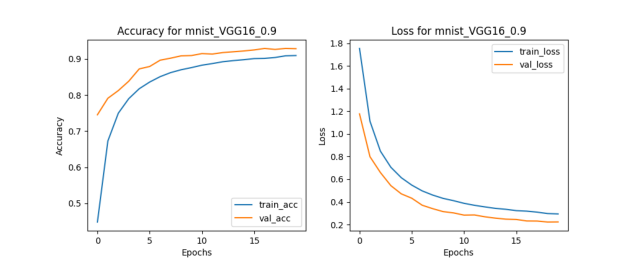

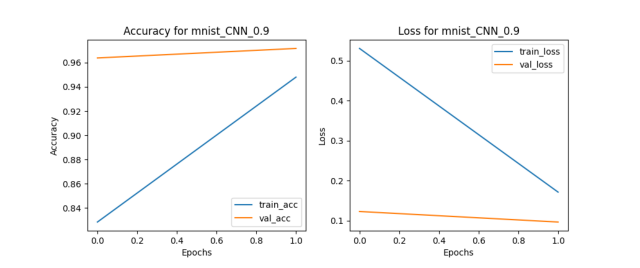

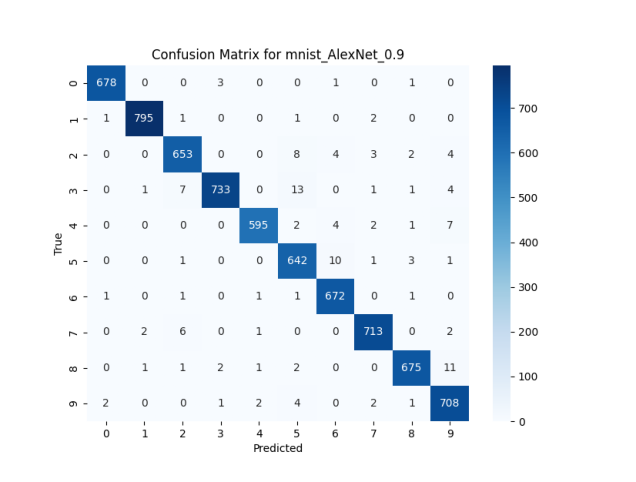

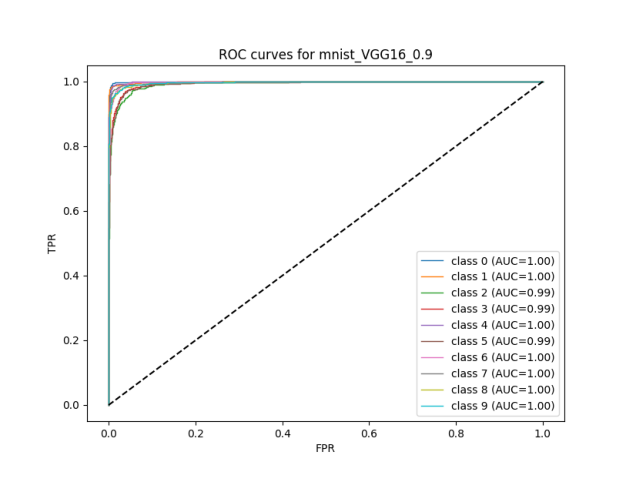

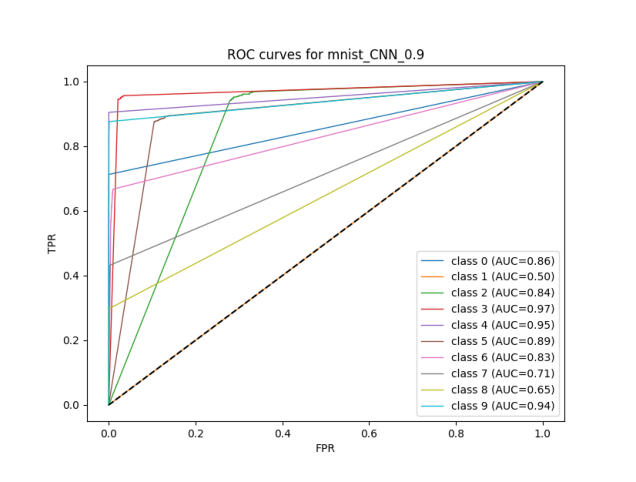

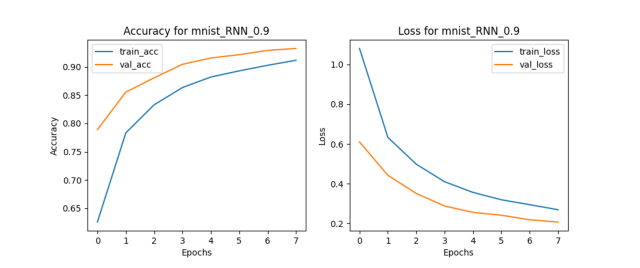

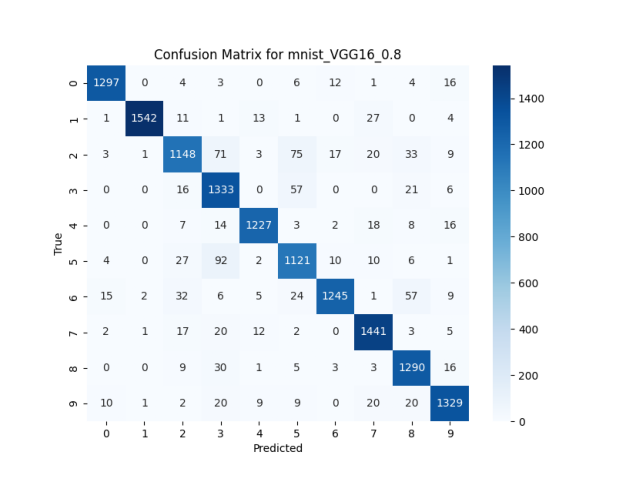

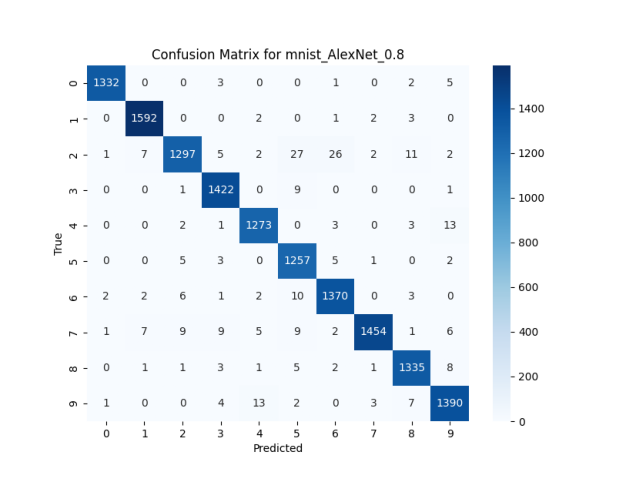

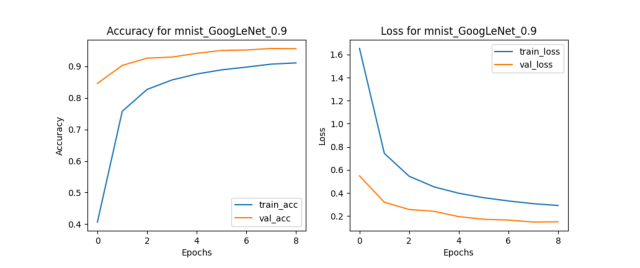

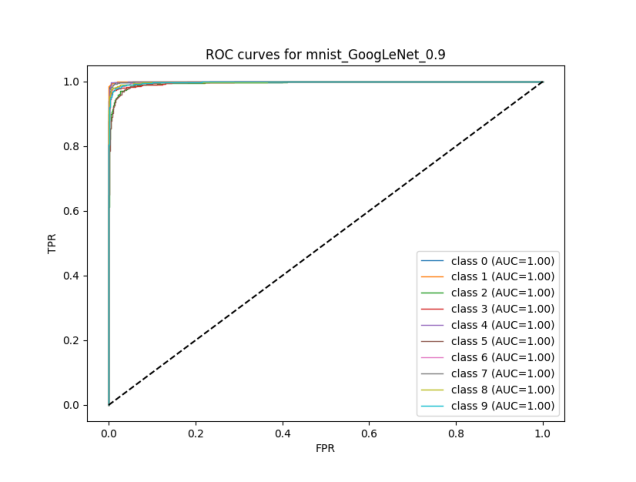

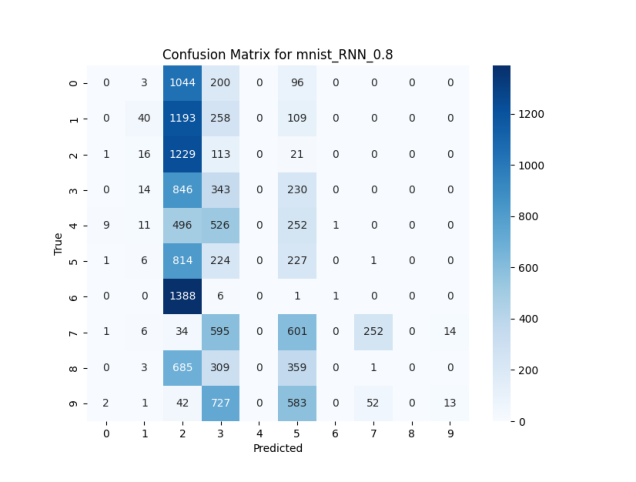

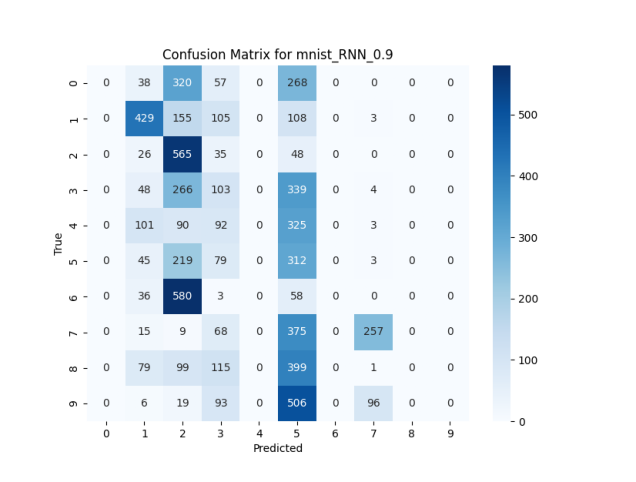

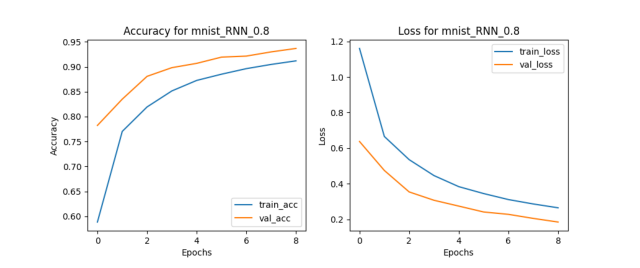

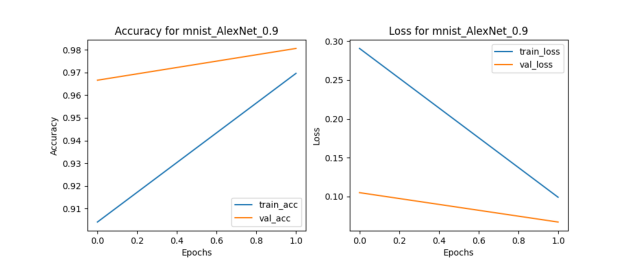

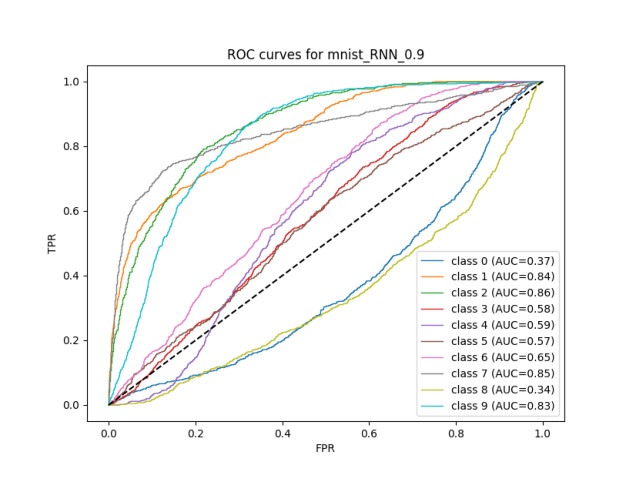

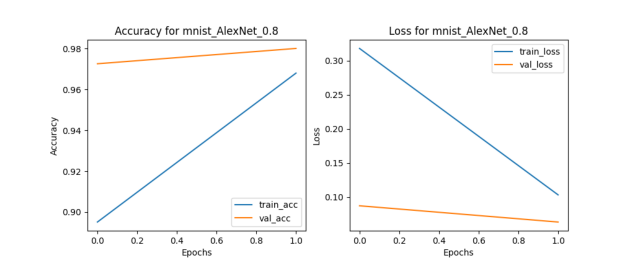

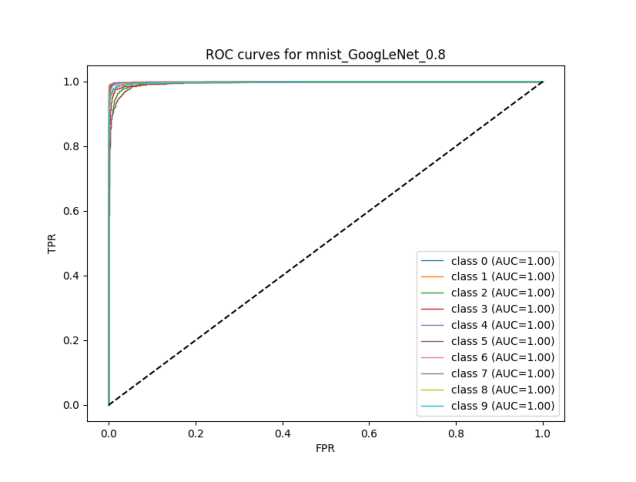

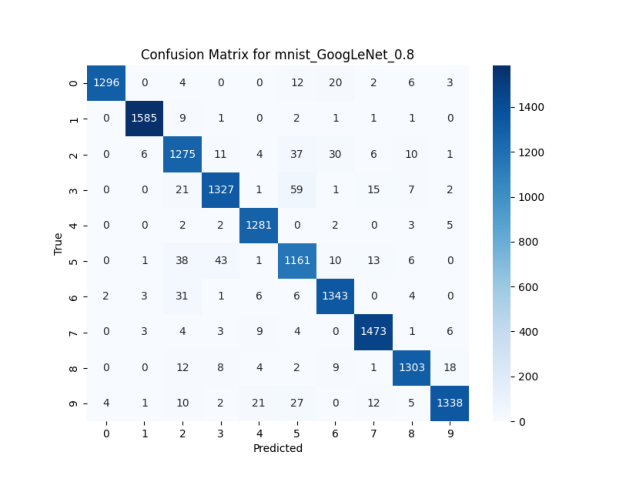

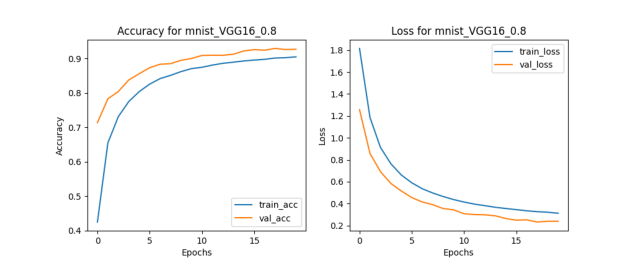

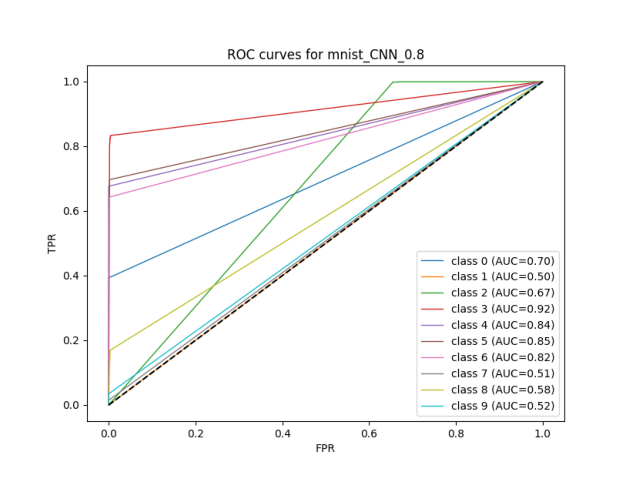

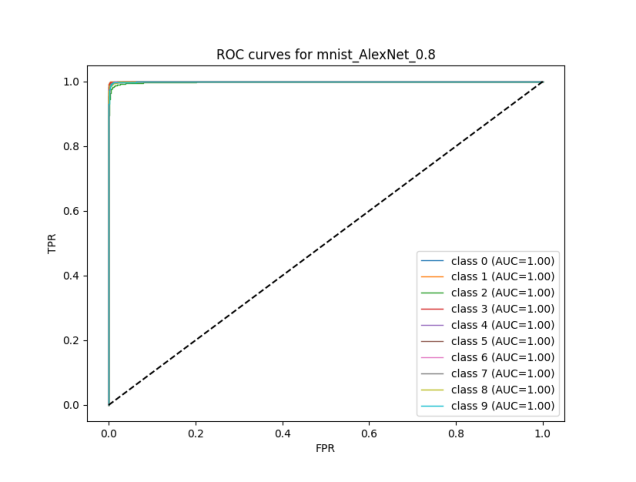

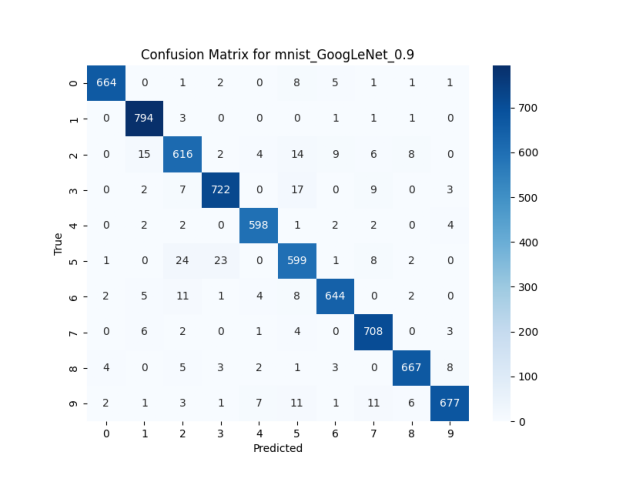

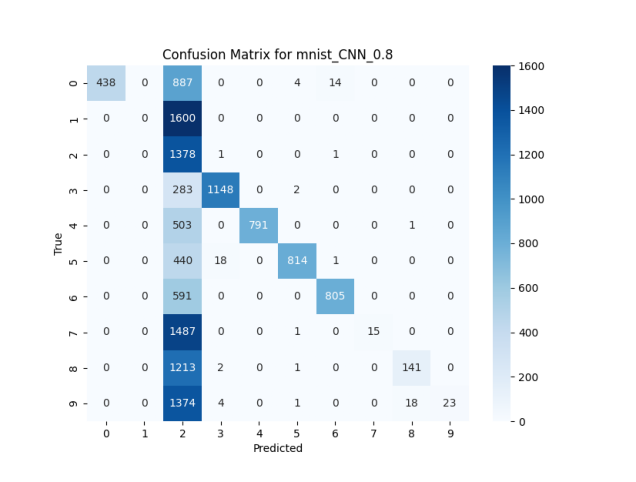

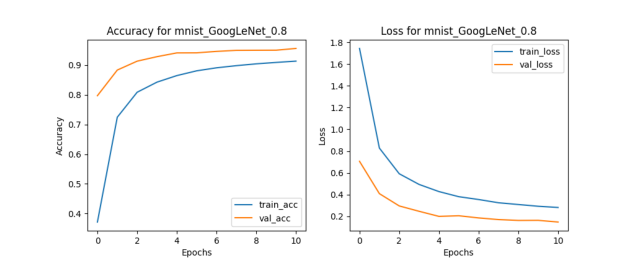

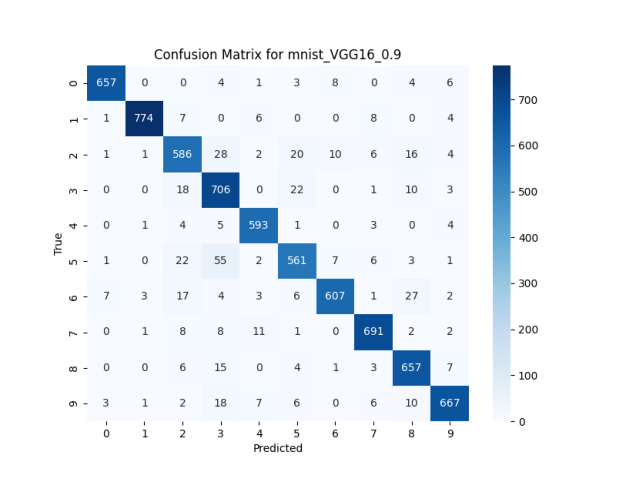

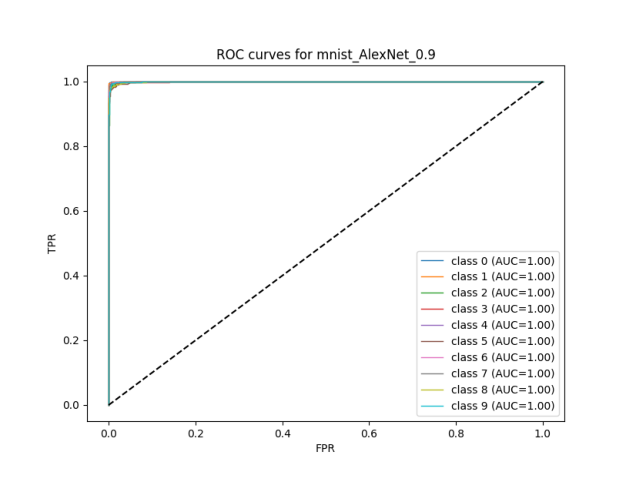

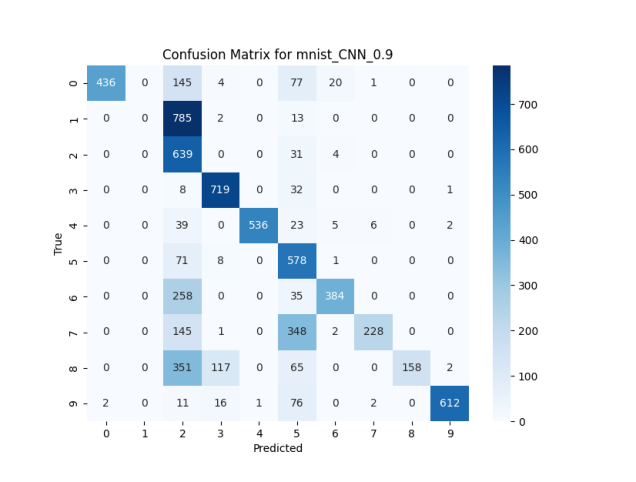

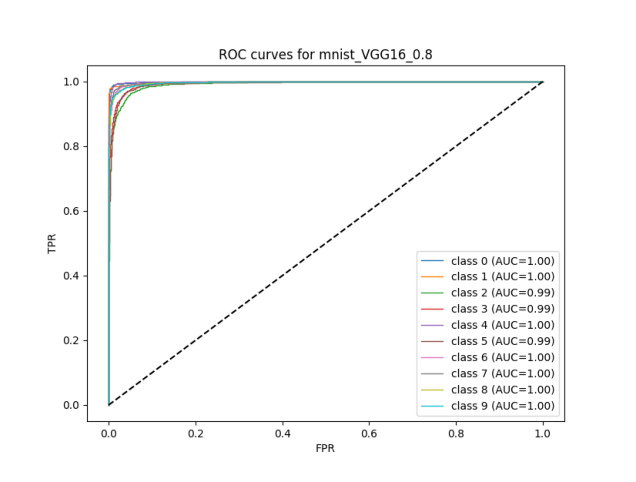

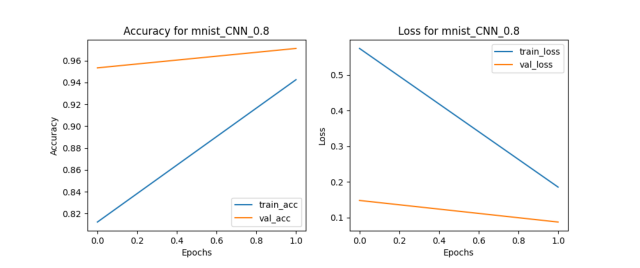

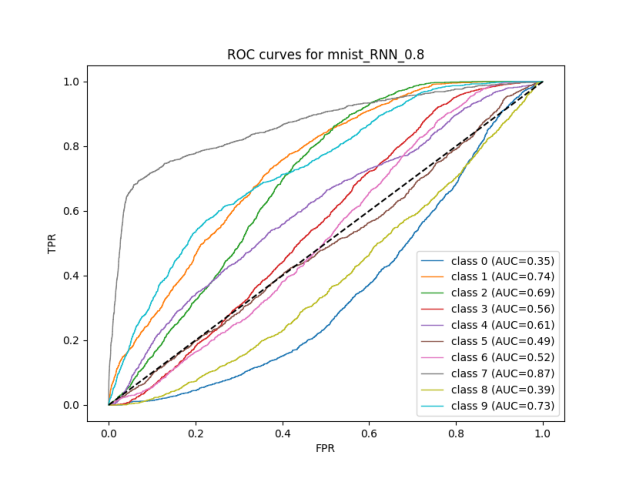

In [24]:
plot_plots("mnist", 'results/plots')

In [ ]:
#df_all= pd.concat([df_cifar, df_mnist], axis=0)
#print(df_all)